# Practice EfficentNet with bad-guy classification datasets

Link to paper: [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks
](https://arxiv.org/pdf/1905.11946.pdf)

## 1. Download dataset

In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [2]:
%cd /content

/content


In [3]:
!mkdir data
%cd data
!kaggle datasets download -d gpiosenka/good-guysbad-guys-image-data-set
!unzip ./good-guysbad-guys-image-data-set.zip

%cd /content

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: train/unsavory/1224.jpg  
  inflating: train/unsavory/1225.jpg  
  inflating: train/unsavory/1226.jpg  
  inflating: train/unsavory/1227.jpg  
  inflating: train/unsavory/1228.jpg  
  inflating: train/unsavory/1229.jpg  
  inflating: train/unsavory/1230.jpg  
  inflating: train/unsavory/1231.jpg  
  inflating: train/unsavory/1232.jpg  
  inflating: train/unsavory/1233.jpg  
  inflating: train/unsavory/1234.jpg  
  inflating: train/unsavory/1235.jpg  
  inflating: train/unsavory/1236.jpg  
  inflating: train/unsavory/1237.jpg  
  inflating: train/unsavory/1238.jpg  
  inflating: train/unsavory/1239.jpg  
  inflating: train/unsavory/1240.jpg  
  inflating: train/unsavory/1241.jpg  
  inflating: train/unsavory/1242.jpg  
  inflating: train/unsavory/1243.jpg  
  inflating: train/unsavory/1244.jpg  
  inflating: train/unsavory/1245.jpg  
  inflating: train/unsavory/1246.jpg  
  inflating: train/unsavory/1247.jpg  
  infla

## 2. Preparing module in need

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import pandas as pd
from math import ceil
import time


import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/bad_guy")

from skimage import io, transform

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 3. Analyst dataset

In [6]:
DATASET_FOLDER = "./data"
TRAIN_FOLDER = f"{DATASET_FOLDER}/train"
TEST_FOLDER = f"{DATASET_FOLDER}/test"
VALID_FOLDER = f"{DATASET_FOLDER}/valid"

INFO_CHARACTER = f"{DATASET_FOLDER}/character.csv"
INFO_CLASS = f"{DATASET_FOLDER}/class_dict.csv"

In [7]:
character_df = pd.read_csv(INFO_CHARACTER)

character_df

,class index,filepaths,labels,data set
0,0,train/savory/0001.jpg,savory,train
1,0,train/savory/0002.jpg,savory,train
2,0,train/savory/0003.jpg,savory,train
3,0,train/savory/0004.jpg,savory,train
4,0,train/savory/0005.jpg,savory,train
...,...,...,...,...
12415,1,valid/unsavory/296.jpg,unsavory,valid
12416,1,valid/unsavory/297.jpg,unsavory,valid
12417,1,valid/unsavory/298.jpg,unsavory,valid
12418,1,valid/unsavory/299.jpg,unsavory,valid


In [8]:
character_df["class index"].value_counts()

0    6210
1    6210
Name: class index, dtype: int64

In [9]:
character_df["data set"].value_counts()

train    11220
test       600
valid      600
Name: data set, dtype: int64

In [10]:
class_df = pd.read_csv(INFO_CLASS)

class_df

,class_index,class,height,width,scale by,Offset
0,0,savory,300,233,1,0
1,1,unsavory,300,233,1,0


In [11]:
class BadGuyDataset(Dataset):
    def __init__(self, csv_file, root_dir, type = "train", transform = None):
        """_summary_

        Args:
            csv_file (string): Path to the csv file
            root_dir (string): Directory with all the images
            type (string): The type of dataset: train, test or valid
            transform (callable, optional): Optional transform to be applied
                on a sample. Defaults to None.
        """
        self.type = type
        self.root_dir = root_dir
        self.transform = transform
        self.df = pd.read_csv(csv_file).groupby("data set").get_group(type)
        
        self.data = np.array([
            io.imread(os.path.join(root_dir,img['filepaths']))
            for img in self.df.iloc
        ])
        self.targets = np.array([
            img['class index']
            for img in self.df.iloc
        ])
        
        self.classes = np.array(class_df['class'])
        
        
        print(f"Found {len(self.df)} data of type {type}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            ids = idx.tolist()
        
        images = self.data[idx]
        labels = self.targets[idx]
        
        if self.transform:
            images = self.transform(images)
        return images, labels   

## Hyperparameters


In [12]:
batch_size = 64
epochs = 30
learning_rate = 1e-3


# Import data

In [13]:
imageTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300), interpolation=InterpolationMode.BICUBIC)
])

train_dataset = BadGuyDataset(csv_file=INFO_CHARACTER, root_dir=DATASET_FOLDER, type="train", transform=imageTransform)
test_dataset = BadGuyDataset(csv_file=INFO_CHARACTER, root_dir=DATASET_FOLDER, type="test", transform=imageTransform)
valid_dataset = BadGuyDataset(csv_file=INFO_CHARACTER, root_dir=DATASET_FOLDER, type="valid", transform=imageTransform)

train_loader = DataLoader(
    dataset=train_dataset,
    drop_last=True,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

Found 11220 data of type train
Found 600 data of type test
Found 600 data of type valid


## Visualize example Data

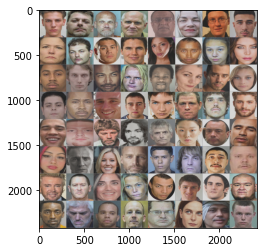

In [41]:
classes = ("BAD GUY", "GOOD GUY")

samples = iter(train_loader)

images, labels = samples.__next__()

imgs = torchvision.utils.make_grid(images, normalize=True, pad_value=0.5)

imgs = imgs.numpy()
imgs = imgs.transpose((1, 2, 0))

plt.imshow(imgs)
plt.show()
# writer.add_image("bad_guy images",imgs)


## Preparing Custom EfficentNet Model

In [15]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3]
] 

phi_values = {
    # tuple of : (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2), #alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes)
        )
    
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate
    
    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int( 32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride = 2, padding = 1)]
        in_channels = channels
        
        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4 * ceil(int(channels * width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)
            
            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size = kernel_size,
                        padding=kernel_size // 2 #if k=1: pad=0, k=3:pad = 1, k=5:pad=2
                    )
                )
                
                in_channels = out_channels
        
        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )
        
        return nn.Sequential(*features)
    
    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

## Training Model

In [16]:
model = EfficientNet(num_classes=2, version="b0")
model = model.to(device)
# writer.add_graph(model, images)

summary(model, (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             864
       BatchNorm2d-2         [-1, 32, 150, 150]              64
              SiLU-3         [-1, 32, 150, 150]               0
          CNNBlock-4         [-1, 32, 150, 150]               0
            Conv2d-5         [-1, 32, 150, 150]             288
       BatchNorm2d-6         [-1, 32, 150, 150]              64
              SiLU-7         [-1, 32, 150, 150]               0
          CNNBlock-8         [-1, 32, 150, 150]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]             264
             SiLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             288
          Sigmoid-13             [-1, 32, 1, 1]               0
SqueezeExcitation-14         [-1, 32, 1

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [27]:
def fit(model, dataloader, isTrain = True):
    if isTrain:
        model.train()
    else:
        model.eval()
    
    running_loss = 0.0
    running_correct = 0
    n_samples = 0
    
    for idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        
        running_loss += loss.item()
        _, preds = torch.max(output, 1)
        
        running_correct += (preds == labels).sum().item()
        n_samples += labels.size(0)
        
        if isTrain:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    process_loss = running_loss / n_samples
    process_acc = 100. * running_correct / n_samples
    type = 'Train' if isTrain else 'Val'
    print(f"{type} Loss: {process_loss:.4f}, {type} Acc: {process_acc:.4f}")

    return process_loss, process_acc
        
        
        

In [28]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1} / {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, train_loader)
    val_epoch_loss, val_epoch_accuracy = fit(model, val_loader, isTrain=False)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    print("-"*10)
end = time.time()
print((end-start)/60, 'minutes')

Epoch 1 / 30
Train Loss: 0.0096, Train Acc: 64.3214
Val Loss: 0.0089, Val Acc: 71.8333
----------
Epoch 2 / 30
Train Loss: 0.0071, Train Acc: 78.7411
Val Loss: 0.0076, Val Acc: 76.3333
----------
Epoch 3 / 30
Train Loss: 0.0057, Train Acc: 83.2679
Val Loss: 0.0067, Val Acc: 81.1667
----------
Epoch 4 / 30
Train Loss: 0.0051, Train Acc: 85.5268
Val Loss: 0.0053, Val Acc: 86.5000
----------
Epoch 5 / 30
Train Loss: 0.0045, Train Acc: 87.5714
Val Loss: 0.0048, Val Acc: 88.5000
----------
Epoch 6 / 30
Train Loss: 0.0042, Train Acc: 88.3750
Val Loss: 0.0044, Val Acc: 89.3333
----------
Epoch 7 / 30
Train Loss: 0.0039, Train Acc: 89.5089
Val Loss: 0.0059, Val Acc: 84.8333
----------
Epoch 8 / 30
Train Loss: 0.0034, Train Acc: 91.0536
Val Loss: 0.0041, Val Acc: 90.5000
----------
Epoch 9 / 30
Train Loss: 0.0032, Train Acc: 91.5268
Val Loss: 0.0053, Val Acc: 87.5000
----------
Epoch 10 / 30
Train Loss: 0.0030, Train Acc: 92.2946
Val Loss: 0.0045, Val Acc: 88.0000
----------
Epoch 11 / 30
Train

## Test Model

In [29]:
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for (image, labels) in test_loader:
        images, labels = image.to(device), labels.to(device)
        
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        
        n_correct += (pred == labels).sum().item()
        n_samples += labels.size(0)
    
    print(f"Accuracy {n_correct / n_samples * 100} %")

Accuracy 94.16666666666667 %


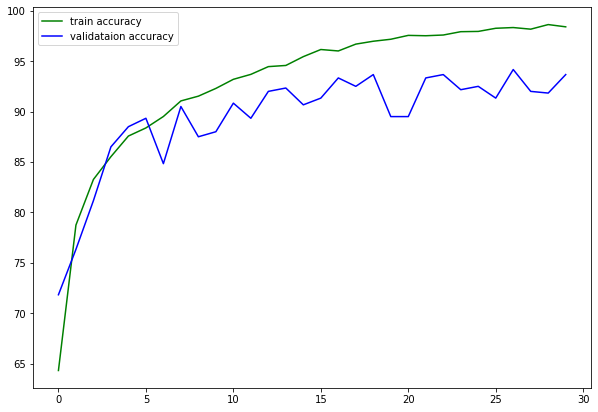

In [30]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

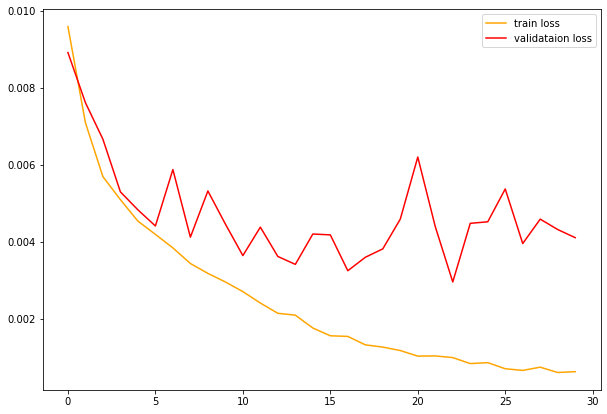

In [31]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

## Test in Images to predict folder

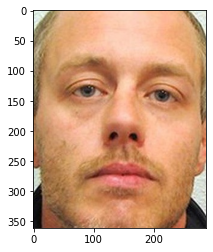

BAD GUY


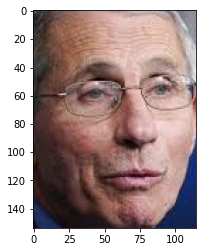

BAD GUY


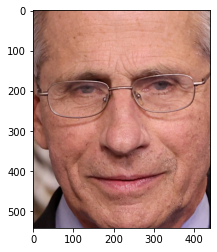

BAD GUY


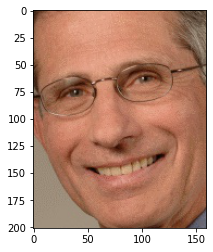

BAD GUY


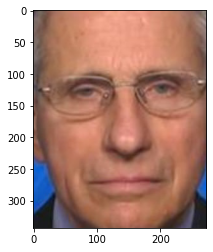

BAD GUY


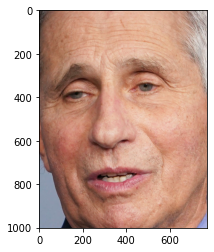

BAD GUY


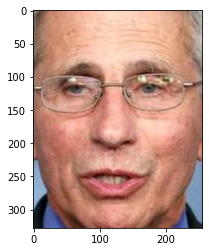

BAD GUY


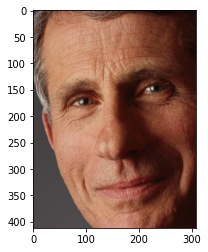

BAD GUY


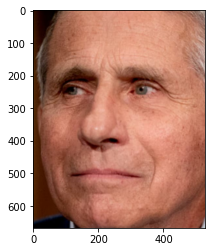

BAD GUY


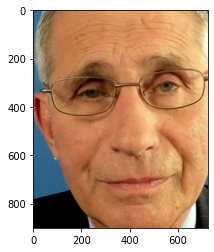

BAD GUY


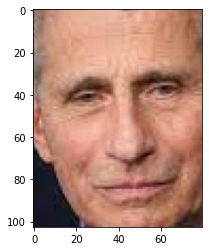

BAD GUY


In [58]:
from PIL import Image

TEST_IMG_PATH = "./data/images to predict"

model.eval()
with torch.no_grad():
  for file in os.listdir(TEST_IMG_PATH):
    img_path = f"{TEST_IMG_PATH}/{file}"
    image = io.imread(img_path)
    plt.imshow(image)
    plt.show()
    image = torch.from_numpy(np.array([image]))
    image = image.permute(0, 3, 1, 2).float().to(device)

    output = model(image)
    _, pred = torch.max(output, 1)
    print(classes[pred.item()])

  